## Imports

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
from pathlib import Path

# ✅ Match Notebook 1 exactly
PROJECT_ROOT = Path(r"C:\Users\tengc\Downloads\metrics-eval\metrics_eval")

META_PATH = PROJECT_ROOT / "data" / "transcription" / "val" / "metadata.csv"

PRED_A = (
    PROJECT_ROOT
    / "models"
    / "transcription"
    / "results"
    / "openai_whisper__whisper-1"
    / "predictions.csv"
)

PRED_B = (
    PROJECT_ROOT
    / "models"
    / "transcription"
    / "results"
    / "faster_whisper__base"
    / "predictions.csv"
)

OUT_COMPARISON = (
    PROJECT_ROOT
    / "models"
    / "transcription"
    / "results"
    / "comparison_openai_whisper__whisper-1__vs__faster_whisper__base.csv"
)

print("META_PATH exists:", META_PATH.exists(), META_PATH)
print("PRED_A exists:", PRED_A.exists(), PRED_A)
print("PRED_B exists:", PRED_B.exists(), PRED_B)

META_PATH exists: True C:\Users\tengc\Downloads\metrics-eval\metrics_eval\data\transcription\val\metadata.csv
PRED_A exists: False C:\Users\tengc\Downloads\metrics-eval\metrics_eval\models\transcription\results\openai_whisper__whisper-1\predictions.csv
PRED_B exists: False C:\Users\tengc\Downloads\metrics-eval\metrics_eval\models\transcription\results\faster_whisper__base\predictions.csv


In [17]:
import subprocess
import sys
import os
from dotenv import load_dotenv

# Ensure OPENAI_API_KEY is available to subprocess (scripts don't auto-load notebook env)
ENV_PATH = PROJECT_ROOT.parent / ".env"
load_dotenv(dotenv_path=ENV_PATH)

def ensure_predictions(pred_path: Path, backend: str, model: str):
    if pred_path.exists():
        print(f"[OK] {backend}__{model} predictions exist")
        return

    print(f"[MISSING] {backend}__{model} predictions not found.")
    print("Running pipeline now...")

    cmd = [
        sys.executable,
        "-m",
        "models.transcription.scripts.run_pipeline",
        "--backend", backend,
        "--model", model,
        "--split", "val",
        "--force",
    ]

    env = os.environ.copy()  # pass OPENAI_API_KEY into subprocess
    print("Command:", " ".join(cmd))
    print("OPENAI_API_KEY in env:", bool(env.get("OPENAI_API_KEY")))
    print("Working dir:", PROJECT_ROOT)

    result = subprocess.run(
        cmd,
        cwd=str(PROJECT_ROOT),
        env=env,
        capture_output=True,
        text=True
    )

    print("Return code:", result.returncode)
    if result.stdout:
        print("\n--- STDOUT ---\n", result.stdout)
    if result.stderr:
        print("\n--- STDERR ---\n", result.stderr)

    if result.returncode != 0:
        raise RuntimeError("Pipeline failed. See STDERR above.")

    print(f"[DONE] Generated: {pred_path}")

# Model A
ensure_predictions(PRED_A, "openai_whisper", "whisper-1")

# Model B
ensure_predictions(PRED_B, "faster_whisper", "base")

[MISSING] openai_whisper__whisper-1 predictions not found.
Running pipeline now...
Command: c:\Users\tengc\miniconda3\envs\capstone\python.exe -m models.transcription.scripts.run_pipeline --backend openai_whisper --model whisper-1 --split val --force
OPENAI_API_KEY in env: True
Working dir: C:\Users\tengc\Downloads\metrics-eval\metrics_eval
Return code: 0

--- STDOUT ---
 [tx_000] done (2.45s)
[tx_001] done (2.21s)
[tx_002] done (3.35s)
[tx_003] done (1.50s)
[tx_004] done (1.57s)
[tx_005] done (1.96s)
[tx_006] done (0.64s)
[tx_007] done (0.98s)
[tx_008] done (0.76s)
[tx_009] done (2.73s)
[tx_010] done (1.51s)
[tx_011] done (1.52s)
[tx_012] done (0.90s)
[tx_013] done (1.01s)
[tx_014] done (1.32s)
[tx_015] done (1.58s)
[tx_016] done (0.81s)
[tx_017] done (1.02s)
[tx_018] done (1.09s)
[tx_019] done (0.90s)
[tx_020] done (1.82s)
[tx_021] done (1.53s)
[tx_022] done (0.70s)
[tx_023] done (1.05s)
[tx_024] done (1.17s)
[tx_025] done (1.06s)
[tx_026] done (1.01s)
[tx_027] done (1.59s)
[tx_028] 

In [18]:
import pandas as pd

assert META_PATH.exists(), f"Missing metadata.csv: {META_PATH}"
assert PRED_A.exists(), f"Missing predictions A: {PRED_A} (run ensure cell above)"
assert PRED_B.exists(), f"Missing predictions B: {PRED_B} (run ensure cell above)"

meta = pd.read_csv(META_PATH)
a = pd.read_csv(PRED_A)
b = pd.read_csv(PRED_B)

meta = meta.rename(columns={"text": "original_text"})[["id", "original_text", "audio_path"]]

a = a.rename(columns={"transcript": "transcript_a", "latency_s": "latency_a"})[["id", "transcript_a", "latency_a", "backend", "model"]]
b = b.rename(columns={"transcript": "transcript_b", "latency_s": "latency_b"})[["id", "transcript_b", "latency_b", "backend", "model"]]

df = meta.merge(a, on="id", how="inner").merge(b, on="id", how="inner")
print("Loaded merged df:", df.shape)
df.head()

Loaded merged df: (30, 11)


,id,original_text,audio_path,transcript_a,latency_a,backend_x,model_x,transcript_b,latency_b,backend_y,model_y
0,tx_000,Product quality is okay overall but the surfac...,C:/Users/tengc/Downloads/metrics-eval/metrics_...,"Product quality is OK overall, but the surface...",2.454494,openai_whisper,whisper-1,"Product quality is okay overall, but the surfa...",8.214057,faster_whisper,base
1,tx_001,Sometimes the delivery driver cannot find the ...,C:/Users/tengc/Downloads/metrics-eval/metrics_...,Sometimes the delivery driver cannot find the ...,2.211589,openai_whisper,whisper-1,Sometimes the delivery driver cannot find the ...,0.672660,faster_whisper,base
2,tx_002,"Stock availability for standard sizes is good,...",C:/Users/tengc/Downloads/metrics-eval/metrics_...,Stock availability for standard sizes is good....,3.350647,openai_whisper,whisper-1,Stock availability for standard sizes is good....,0.696889,faster_whisper,base
3,tx_003,The sales engineer knows our project requireme...,C:/Users/tengc/Downloads/metrics-eval/metrics_...,The sales engineer knows our project requireme...,1.497712,openai_whisper,whisper-1,The sales engineer knows our project requireme...,0.711875,faster_whisper,base
4,tx_004,Delivery is usually on time but sometimes the ...,C:/Users/tengc/Downloads/metrics-eval/metrics_...,"Delivery is usually on time, but sometimes the...",1.568669,openai_whisper,whisper-1,"Delivery is usually on time, but sometimes the...",0.728321,faster_whisper,base


## Metrics

In [19]:
from jiwer import wer, cer
import re

def normalize_for_asr(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower().strip()
    # remove punctuation (keep alphanumerics + whitespace)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    # collapse whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s

def compute_wer(ref: str, hyp: str) -> float:
    return wer(normalize_for_asr(ref), normalize_for_asr(hyp))

def compute_cer(ref: str, hyp: str) -> float:
    return cer(normalize_for_asr(ref), normalize_for_asr(hyp))

In [20]:
df["wer_a"] = df.apply(lambda r: compute_wer(r["original_text"], r["transcript_a"]), axis=1)
df["cer_a"] = df.apply(lambda r: compute_cer(r["original_text"], r["transcript_a"]), axis=1)

df["wer_b"] = df.apply(lambda r: compute_wer(r["original_text"], r["transcript_b"]), axis=1)
df["cer_b"] = df.apply(lambda r: compute_cer(r["original_text"], r["transcript_b"]), axis=1)

# Optional: notes column for manual tagging later
if "notes" not in df.columns:
    df["notes"] = ""

cols = [
    "id",
    "original_text",
    "transcript_a",
    "transcript_b",
    "wer_a",
    "cer_a",
    "wer_b",
    "cer_b",
    "latency_a",
    "latency_b",
    "notes",
]
table = df[cols].sort_values("id").reset_index(drop=True)
table.head()

,id,original_text,transcript_a,transcript_b,wer_a,cer_a,wer_b,cer_b,latency_a,latency_b,notes
0,tx_000,Product quality is okay overall but the surfac...,"Product quality is OK overall, but the surface...","Product quality is okay overall, but the surfa...",0.066667,0.022989,0.0,0.0,2.454494,8.214057,
1,tx_001,Sometimes the delivery driver cannot find the ...,Sometimes the delivery driver cannot find the ...,Sometimes the delivery driver cannot find the ...,0.000000,0.000000,0.0,0.0,2.211589,0.672660,
2,tx_002,"Stock availability for standard sizes is good,...",Stock availability for standard sizes is good....,Stock availability for standard sizes is good....,0.000000,0.000000,0.0,0.0,3.350647,0.696889,
3,tx_003,The sales engineer knows our project requireme...,The sales engineer knows our project requireme...,The sales engineer knows our project requireme...,0.000000,0.000000,0.0,0.0,1.497712,0.711875,
4,tx_004,Delivery is usually on time but sometimes the ...,"Delivery is usually on time, but sometimes the...","Delivery is usually on time, but sometimes the...",0.000000,0.000000,0.0,0.0,1.568669,0.728321,


In [21]:
table.to_csv(OUT_COMPARISON, index=False, encoding="utf-8")
print("Saved comparison:", OUT_COMPARISON)

Saved comparison: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\models\transcription\results\comparison_openai_whisper__whisper-1__vs__faster_whisper__base.csv


## Stats

In [22]:
summary = pd.DataFrame({
    "metric": ["mean_wer", "median_wer", "mean_cer", "median_cer", "mean_latency_s", "median_latency_s"],
    "model_a": [
        table["wer_a"].mean(),
        table["wer_a"].median(),
        table["cer_a"].mean(),
        table["cer_a"].median(),
        table["latency_a"].mean(),
        table["latency_a"].median(),
    ],
    "model_b": [
        table["wer_b"].mean(),
        table["wer_b"].median(),
        table["cer_b"].mean(),
        table["cer_b"].median(),
        table["latency_b"].mean(),
        table["latency_b"].median(),
    ],
})
summary


,metric,model_a,model_b
0,mean_wer,0.010327,0.011944
1,median_wer,0.000000,0.000000
2,mean_cer,0.004629,0.001620
3,median_cer,0.000000,0.000000
4,mean_latency_s,1.399799,0.988882
5,median_latency_s,1.159873,0.717044


### WER dist

C:\Users\tengc\AppData\Local\Temp\ipykernel_12988\466682856.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([table["wer_a"], table["wer_b"]], labels=["Model A", "Model B"])


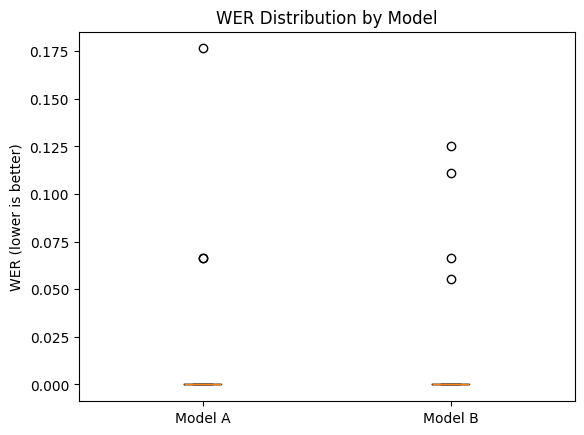

In [23]:
plt.figure()
plt.boxplot([table["wer_a"], table["wer_b"]], labels=["Model A", "Model B"])
plt.ylabel("WER (lower is better)")
plt.title("WER Distribution by Model")
plt.show()

### CER dist

C:\Users\tengc\AppData\Local\Temp\ipykernel_12988\1969161091.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([table["cer_a"], table["cer_b"]], labels=["Model A", "Model B"])


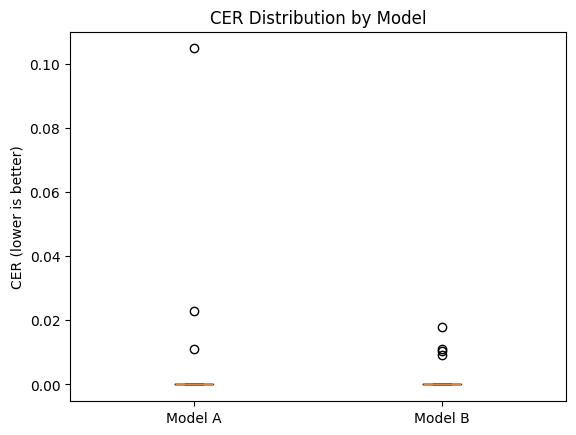

In [24]:
plt.figure()
plt.boxplot([table["cer_a"], table["cer_b"]], labels=["Model A", "Model B"])
plt.ylabel("CER (lower is better)")
plt.title("CER Distribution by Model")
plt.show()

### Mean WER/CER side-by-side (simple bar chart)

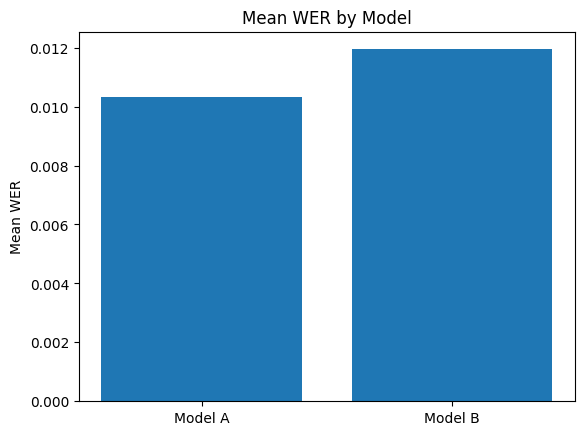

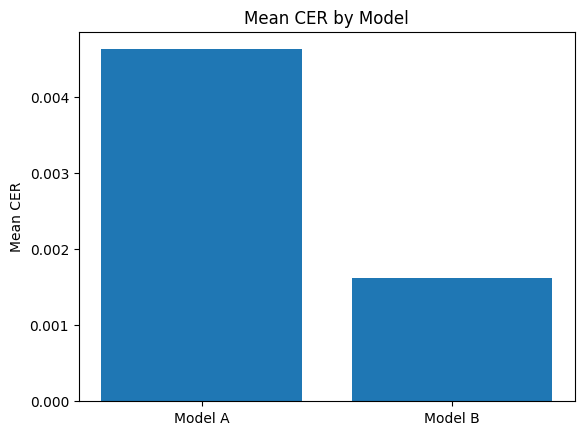

In [25]:
means = pd.DataFrame({
    "model": ["Model A", "Model B"],
    "mean_wer": [table["wer_a"].mean(), table["wer_b"].mean()],
    "mean_cer": [table["cer_a"].mean(), table["cer_b"].mean()],
})

plt.figure()
plt.bar(means["model"], means["mean_wer"])
plt.ylabel("Mean WER")
plt.title("Mean WER by Model")
plt.show()

plt.figure()
plt.bar(means["model"], means["mean_cer"])
plt.ylabel("Mean CER")
plt.title("Mean CER by Model")
plt.show()

### Worst Cases

In [26]:
# Show the 10 worst WER cases for each model
worst_a = table.sort_values("wer_a", ascending=False).head(10)
worst_b = table.sort_values("wer_b", ascending=False).head(10)

print("Worst 10 - Model A (by WER):")
display(worst_a[["id", "original_text", "transcript_a", "wer_a", "cer_a"]])

print("Worst 10 - Model B (by WER):")
display(worst_b[["id", "original_text", "transcript_b", "wer_b", "cer_b"]])

Worst 10 - Model A (by WER):


,id,original_text,transcript_a,wer_a,cer_a
21,tx_021,Recent deliveries have been consistently late ...,Recent deliveries have been consistently late ...,0.176471,0.104762
0,tx_000,Product quality is okay overall but the surfac...,"Product quality is OK overall, but the surface...",0.066667,0.022989
18,tx_018,It sometimes feels like our smaller orders are...,It sometimes feels like our smaller orders are...,0.066667,0.011111
1,tx_001,Sometimes the delivery driver cannot find the ...,Sometimes the delivery driver cannot find the ...,0.000000,0.000000
28,tx_028,Overall we are satisfied with the product qual...,"Overall, we are satisfied with the product qua...",0.000000,0.000000
27,tx_027,Product dimensions are accurate and we have no...,"Product dimensions are accurate, and we have n...",0.000000,0.000000
26,tx_026,Sales team is very responsive on WhatsApp and ...,Sales team is very responsive on WhatsApp and ...,0.000000,0.000000
25,tx_025,One batch was completely missed from the deliv...,One batch was completely missed from the deliv...,0.000000,0.000000
24,tx_024,It took a long time to process a refund when w...,It took a long time to process a refund when w...,0.000000,0.000000
23,tx_023,Material specs sometimes do not match the draw...,Material specs sometimes do not match the draw...,0.000000,0.000000


Worst 10 - Model B (by WER):


,id,original_text,transcript_b,wer_b,cer_b
19,tx_019,"Pipe casting quality is excellent, no defects ...",Pipe casting quality is excellent. No defects ...,0.125000,0.018018
13,tx_013,We frequently encounter no stock for common it...,We frequently encounter no stock for common it...,0.111111,0.009174
18,tx_018,It sometimes feels like our smaller orders are...,It sometimes feels like our smaller orders are...,0.066667,0.011111
12,tx_012,We found surface rust on some ductile iron pie...,We found surface rest on some ductile iron pie...,0.055556,0.010309
0,tx_000,Product quality is okay overall but the surfac...,"Product quality is okay overall, but the surfa...",0.000000,0.000000
16,tx_016,Casting of manhole covers is robust and passes...,Casting of manhole covers is robust and passes...,0.000000,0.000000
28,tx_028,Overall we are satisfied with the product qual...,"Overall, we are satisfied with the product qua...",0.000000,0.000000
27,tx_027,Product dimensions are accurate and we have no...,Product dimensions are accurate and we have no...,0.000000,0.000000
26,tx_026,Sales team is very responsive on WhatsApp and ...,Sales team is very responsive on WhatsApp and ...,0.000000,0.000000
25,tx_025,One batch was completely missed from the deliv...,One batch was completely missed from the deliv...,0.000000,0.000000
